In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from poola import core as pool
import gpplot as gpp
gpp.set_aesthetics(context = 'paper')

In [106]:
#define file path
file_path = '../../Data/externalData/'

#read in extra details about sequencing
seq_detail = pd.read_table(file_path+"CRISPRicin library 20130912_final_draft_CRISPRicin.txt", header = None)
#read in read counts
seq_count = pd.read_table(file_path + '20230811_counts_files_combined.txt')
seq_count = seq_count[['0', 'dCas9-KRAB ricin LG',  
       'dCas9-KRAB ricin MH', 'dCas9-KRAB untreated MH',
       'dCas9-KRAB untreated LG']]
seq_count = seq_count.rename(columns = {'0':'guide id'})
seq_count

,guide id,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH,dCas9-KRAB untreated MH,dCas9-KRAB untreated LG
0,ARCN1_c_118438373.25,30.0,24.0,50.0,90.0
1,ARCN1_c_118438478.24,951.0,805.0,650.0,955.0
2,ARCN1_c_118438478.26,796.0,486.0,399.0,430.0
3,ARCN1_c_118438508.26,1021.0,527.0,555.0,825.0
4,ARCN1_c_118438682.27,642.0,865.0,656.0,835.0
...,...,...,...,...,...
55495,negYIPF5_c_143553099.25,397.0,152.0,192.0,272.0
55496,negYIPF5_c_143553316.27,366.0,133.0,404.0,544.0
55497,negYIPF5_w_143550317.26,771.0,539.0,449.0,603.0
55498,negYIPF5_w_143553763.25,1022.0,1441.0,853.0,1058.0


In [107]:
#filter guides with low representation in pDNA
lognorms_tiling = pool.lognorm_columns(reads_df=seq_count, columns=['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH', 
                                                                          'dCas9-KRAB untreated MH','dCas9-KRAB untreated LG'])
filtered_lognorms_tiling = pool.filter_pdna(lognorm_df=lognorms_tiling, 
                                                  pdna_cols=['dCas9-KRAB untreated MH','dCas9-KRAB untreated LG'], z_low=-3)
print('Filtered ' + str(lognorms_tiling.shape[0] - filtered_lognorms_tiling.shape[0]) + ' rows due to low pDNA abundance')

Filtered 1092 rows due to low pDNA abundance


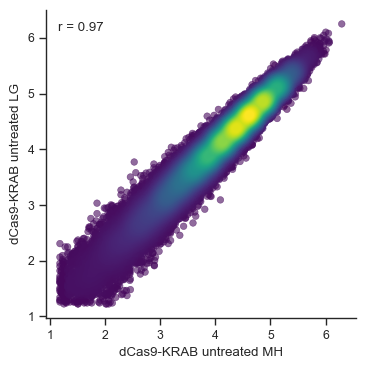

In [108]:
# use check correlation between lognorms for the two pDNA conditions to decide whether they can be averaged
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=filtered_lognorms_tiling, x='dCas9-KRAB untreated MH', y='dCas9-KRAB untreated LG')
gpp.add_correlation(data=filtered_lognorms_tiling, x='dCas9-KRAB untreated MH', y='dCas9-KRAB untreated LG')
sns.despine()

In [109]:
#find average lognorms of T0 because they correlate well
filtered_lognorms_tiling['avgCountsUntreated'] = filtered_lognorms_tiling[['dCas9-KRAB untreated MH', 'dCas9-KRAB untreated LG']].mean(axis=1)

In [110]:
# calculate log-fold changes with respect to average untreated condition
lfc_tiling = pool.calculate_lfcs(lognorm_df=filtered_lognorms_tiling, 
                                         ref_col='avgCountsUntreated', 
                                       target_cols=['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH'])
lfc_tiling = lfc_tiling[['guide id', 'dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH']]
lfc_tiling.head()

,guide id,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH
0,ARCN1_c_118438373.25,-0.914327,-0.945535
1,ARCN1_c_118438478.24,-0.200292,-0.195294
2,ARCN1_c_118438478.26,0.434630,-0.004084
3,ARCN1_c_118438508.26,0.108739,-0.563859
4,ARCN1_c_118438682.27,-0.651167,-0.009016


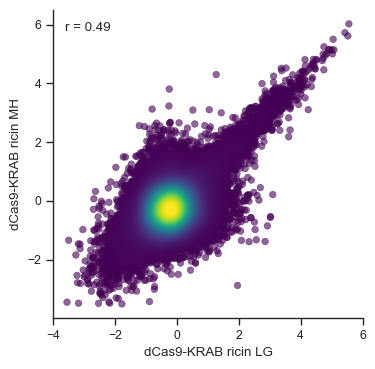

In [111]:
#remove NAs
lfc_tiling = lfc_tiling.dropna()

#check LFC correlations between two replicates
plt.subplots(figsize=(4,4))
gpp.point_densityplot(data=lfc_tiling, x='dCas9-KRAB ricin LG', y='dCas9-KRAB ricin MH')
gpp.add_correlation(data=lfc_tiling, x='dCas9-KRAB ricin LG', y='dCas9-KRAB ricin MH')
sns.despine()

In [112]:
# average LFCs across replicates since they correlate decently
lfc_tiling['Avg_LFC'] = lfc_tiling[['dCas9-KRAB ricin LG', 'dCas9-KRAB ricin MH']].mean(axis=1)

In [113]:
#total guides?
len(lfc_tiling)

54403

In [114]:
# calcuate z-score relative to negative controls
nc_mean = lfc_tiling[lfc_tiling['guide id'].str[:3] == "neg"]['Avg_LFC'].mean()
nc_mean_std = lfc_tiling[lfc_tiling['guide id'].str[:3] == "neg"]['Avg_LFC'].std()
lfc_tiling['zscoreRelativeNC'] = (lfc_tiling['Avg_LFC'] - nc_mean)/nc_mean_std

In [115]:
#merge with df containing oligo sequences
dcas_krab = pd.merge(lfc_tiling,seq_detail.rename(columns = {0: 'guide id', 1: 'oligo'}), 
                     on = 'guide id' ).dropna()

In [116]:
#extract gene and position from guide id
dcas_krab[['Gene', 'Position']] = dcas_krab['guide id'].str.split(pat = '_', n = 1, expand=True)
dcas_krab.head()

,guide id,dCas9-KRAB ricin LG,dCas9-KRAB ricin MH,Avg_LFC,zscoreRelativeNC,oligo,Gene,Position
0,ARCN1_c_118438373.25,-0.914327,-0.945535,-0.929931,-2.063088,cccttggagaaCCAcctTGTTGGAAAACCTACCAGAGGTAAACAGT...,ARCN1,c_118438373.25
1,ARCN1_c_118438478.24,-0.200292,-0.195294,-0.197793,0.067421,cccttggagaaCCAcctTGTTGGATCTGTTTTGCTCGtaatagGTT...,ARCN1,c_118438478.24
2,ARCN1_c_118438478.26,0.434630,-0.004084,0.215273,1.269436,cccttggagaaCCAcctTGTTGGTGATCTGTTTTGCTCGtaatagG...,ARCN1,c_118438478.26
3,ARCN1_c_118438508.26,0.108739,-0.563859,-0.227560,-0.019199,cccttggagaaCCAcctTGTTGgtaatgtgcagtacttactatgtG...,ARCN1,c_118438508.26
4,ARCN1_c_118438682.27,-0.651167,-0.009016,-0.330092,-0.317565,cccttggagaaCCAcctTGTTGgcgctgaaaatagcagccaaacac...,ARCN1,c_118438682.27


In [117]:
# Drop negative controls and mismatches 
tiling_crispri = dcas_krab[dcas_krab['guide id'].str[:3] != "neg"]
tiling_crispri = tiling_crispri[tiling_crispri['guide id'].str[:3] != "mis"]
len(tiling_crispri)

52541

In [118]:
tiling_crispri["gene symbol"] = tiling_crispri['guide id'].str.split("_").str[0]
tiling_crispri["temp"] = tiling_crispri['guide id'].str.split("_").str[2]
tiling_crispri["pam coordinate (hg19)"] = tiling_crispri.temp.str.split(".").str[0]
tiling_crispri["length (including pam)"] = tiling_crispri.temp.str.split(".").str[1]
tiling_crispri.drop('temp', axis=1, inplace=True)

In [119]:
tiling_crispri.drop('Position', axis=1, inplace=True)
tiling_crispri.drop('Gene', axis=1, inplace=True)

In Horlbeck et al., 2016 (https://elifesciences.org/articles/12677v2) a CRISPRko ricin tiling screen was performed with the same library. We cleaned those data to obtain the sgRNA sequences corresponding to each guide in the library (see details in Methods).

In [1]:
tiling_crispri["pam coordinate (hg19)"] = tiling_crispri["pam coordinate (hg19)"].astype(np.int64)
tiling_crispri["length (including pam)"] = tiling_crispri["length (including pam)"].astype(np.int64)

# The PAM site from the CRISPRko data seems to be off by 1 from the CRISPRi data
tiling_crispri["pam coordinate (hg19) - 1"] = tiling_crispri["pam coordinate (hg19)"] - 1
tiling_crispri

NameError: name 'tiling_crispri' is not defined

In [121]:
# check if theres any duplicates on the columns we are going to merge on 
tiling_crispri[['gene symbol', 'length (including pam)', 'pam coordinate (hg19) - 1']].duplicated().any()

False

In [62]:
#read in cleaned CRISPRko tiling data
tiling_crisprko = pd.read_csv(file_path+'cleaned_horlbeck_2016_tiling.csv')

tiling_crisprko[['gene symbol', 'sgRNA length (including PAM)','PAM genomic coordinate [hg19]']].duplicated().any()

False

In [123]:
merged_tiling = pd.merge(tiling_crispri, tiling_crisprko, 
         left_on = ['gene symbol', 'length (including pam)', 'pam coordinate (hg19) - 1'],
         right_on = ['gene symbol', 'sgRNA length (including PAM)','PAM genomic coordinate [hg19]'])

In [124]:
# check that all oligos are unique
merged_tiling['oligo'].value_counts().value_counts()

count
1    51101
Name: count, dtype: int64

In [125]:
# check that all sgRNA sequence are unique
merged_tiling['sgRNA sequence'].value_counts().value_counts()

count
1    51101
Name: count, dtype: int64

In [126]:
# number of rows for which the sgRNA sequence in the CRISPRko data can be found within the oligo in the CRISPRi data
sum(merged_tiling.apply(lambda row: row['sgRNA sequence'] in row['oligo'],axis=1))

51101

In [127]:
merged_tiling[['gene symbol', 'chromosome', 'strand targeted','PAM genomic coordinate [hg38]']].nunique()

gene symbol                         48
chromosome                          16
strand targeted                      2
PAM genomic coordinate [hg38]    29243
dtype: int64

In [128]:
#read in data file with context sequences for cleaned crisprko data
crisprko_with_context_seqs = pd.read_csv(file_path + 'Dany-horlbeck-tiling-with-rs3.csv')
crisprko_with_context_seqs.head()

,gene symbol,chromosome,strand targeted,hg38_coord,context seq,Position relative to FANTOM5 TSS,absolute z-score,rs3 score
0,ARCN1,chr11,+,118567638.0,GCACTTTCCTTGTTTACCTCTGGTAGGTTT,-4793.0,0.409907,-0.067121
1,ARCN1,chr11,+,118567850.0,ATTGGCAGTAACATCTATCTCATAAGGTTG,-4581.0,0.694579,-0.554137
2,ARCN1,chr11,+,118567997.0,TCCCATAGTGGCAGTATCTTATAATGGTTA,-4434.0,0.566546,-0.090399
3,ARCN1,chr11,+,118568013.0,CATGCTTCTTGAGGAGTCCCATAGTGGCAG,-4418.0,0.997859,0.220064
4,ARCN1,chr11,+,118568026.0,GCAACCCTGTAAGCATGCTTCTTGAGGAGT,-4405.0,0.386895,-0.563347


Some guides are 25 nucleotides long. Since our context sequences are 30 nucleotides in length and add 6 base pairs downstream of the guide, this results in one nucleotide being cut off from the context sequence. Therefore, we remove 25 nt guides (which can be identified as those with a guide id ending in "28").

In [129]:
merged_tiling['length'] = merged_tiling['guide id'].str[-2:]
merged_tiling = merged_tiling[merged_tiling['length'] != '28']

In [130]:
merged_tiling_w_context = pd.merge(
         crisprko_with_context_seqs[['gene symbol', 'chromosome', 'strand targeted', 'hg38_coord',
       'context seq']].rename(columns={'hg38_coord':'PAM genomic coordinate [hg38]'}),
    merged_tiling[['guide id', 'oligo', 'gene symbol', 'chromosome',
       'strand targeted', 'sgRNA sequence','PAM genomic coordinate [hg38]','zscoreRelativeNC','Avg_LFC']],
         on = ['gene symbol', 'chromosome', 'strand targeted','PAM genomic coordinate [hg38]'],
                     how = 'inner')

In [131]:
merged_tiling_w_context['context seq'].value_counts().value_counts()

count
1    14320
2     7368
3     2541
4      510
5       58
Name: count, dtype: int64

In [132]:
# check out duplicated context seq
duplicated_df_same_gene = merged_tiling_w_context[merged_tiling_w_context[['context seq','gene symbol']].duplicated(keep = False)]
duplicated_df_same_gene

,gene symbol,chromosome,strand targeted,PAM genomic coordinate [hg38],context seq,guide id,oligo,sgRNA sequence,zscoreRelativeNC,Avg_LFC
2,ARCN1,chr11,+,118568080.0,GATGCTGCTTCTTCGGAAATATAACGGTAG,ARCN1_w_118438796.24,cccttggagaaCCAcctTGTTGGCTGCTTCTTCGGAAATATAAGTT...,GCTGCTTCTTCGGAAATATAA,-0.625329,-0.435853
3,ARCN1,chr11,+,118568080.0,GATGCTGCTTCTTCGGAAATATAACGGTAG,ARCN1_w_118438796.27,cccttggagaaCCAcctTGTTGGATGCTGCTTCTTCGGAAATATAA...,GATGCTGCTTCTTCGGAAATATAA,1.058009,0.142617
10,ARCN1,chr11,+,118569662.0,CAGAGAAGAAAACTATCCCACCACAGGTCT,ARCN1_w_118440378.23,cccttggagaaCCAcctTGTTGgaagaaaactatcccaccacGTTT...,gaagaaaactatcccaccac,-2.038755,-0.921569
11,ARCN1,chr11,+,118569662.0,CAGAGAAGAAAACTATCCCACCACAGGTCT,ARCN1_w_118440378.25,cccttggagaaCCAcctTGTTGgagaagaaaactatcccaccacGT...,gagaagaaaactatcccaccac,0.174085,-0.161138
17,ARCN1,chr11,+,118572257.0,TAGGGGGCGTTCACCCTCCAGCTGTGGAAC,ARCN1_w_118442973.24,cccttggagaaCCAcctTGTTGGGGGCGTTCACCCTCCAGCTGGTT...,GGGGCGTTCACCCTCCAGCTG,-1.295481,-0.666147
...,...,...,...,...,...,...,...,...,...,...
39002,YIPF5,chr5,-,144175026.0,GGGAGATAATATGAAAAACAGCACGGGAGA,YIPF5_c_143554590.26,cccttggagaaCCAcctTGTTGggagataatatgaaaaacagcacG...,ggagataatatgaaaaacagcac,-0.759968,-0.482121
39003,YIPF5,chr5,-,144175026.0,GGGAGATAATATGAAAAACAGCACGGGAGA,YIPF5_c_143554590.27,cccttggagaaCCAcctTGTTGgggagataatatgaaaaacagcac...,gggagataatatgaaaaacagcac,-0.049714,-0.238046
39005,YIPF5,chr5,-,144175074.0,TGATGGCAAAGCCACTCATGCCAAAGGTAA,YIPF5_c_143554638.22,cccttggagaaCCAcctTGTTGgcaaagccactcatgccaaGTTTA...,gcaaagccactcatgccaa,0.200574,-0.152036
39006,YIPF5,chr5,-,144175074.0,TGATGGCAAAGCCACTCATGCCAAAGGTAA,YIPF5_c_143554638.23,cccttggagaaCCAcctTGTTGggcaaagccactcatgccaaGTTT...,ggcaaagccactcatgccaa,0.492083,-0.051860


In [133]:
# check that all duplicate context seqs target the same gene
len(merged_tiling_w_context[merged_tiling_w_context[['context seq']].duplicated(keep = False)]) == len(duplicated_df_same_gene)

True

In [134]:
# if the duplicated context seq are within the same gene then take the average z-score and LFC
for seq in duplicated_df_same_gene['context seq'].unique():
    seq_df = merged_tiling_w_context[merged_tiling_w_context['context seq'] == seq]
    if len(set(seq_df['gene symbol'])) == 1:
        merged_tiling_w_context.loc[seq_df.index,'zscoreRelativeNC'] = seq_df['zscoreRelativeNC'].mean()
        merged_tiling_w_context.loc[seq_df.index,'Avg_LFC'] = seq_df['Avg_LFC'].mean()

In [89]:
cleaned_df = merged_tiling_w_context.drop_duplicates(['gene symbol','context seq'], keep = 'first').copy()

In [135]:
# no duplicates
cleaned_df[cleaned_df.duplicated()]

,gene symbol,chromosome,strand targeted,PAM genomic coordinate [hg38],context seq,guide id,oligo,sgRNA sequence,zscoreRelativeNC,Avg_LFC,sgRNA sequence in Context


In [136]:
#no duplicate context sequences
cleaned_df['context seq'].nunique() == len(cleaned_df)

True

In [137]:
#any context sequences with incorrect nucleotides where the PAM should be?
sum(cleaned_df['context seq'].str[25:27] != 'GG')

0

In [138]:
cleaned_df['sgRNA sequence in Context'] = cleaned_df.apply(lambda row: row['sgRNA sequence'].upper() in row['context seq'].upper(),
                     axis=1)
# only kept rows with sgRNA in Context
cleaned_df = cleaned_df[cleaned_df['sgRNA sequence in Context'] == True]

In [96]:
len(cleaned_df)

24791

Use the referenced Bassik et al., 2013 (https://pubmed.ncbi.nlm.nih.gov/23394947/) to identify ricin-associated genes.

In [101]:
#read in dataframe with target gene function with respect to ricin
ricin_gene = pd.read_csv(file_path + 'CRISPRricin compiled all sgRNA data with phenotype-signed z scores.csv') 
ricin_gene = ricin_gene[['gene','Target Gene Function']].drop_duplicates()
ricin_gene

,gene,Target Gene Function
0,ARCN1,Resistance
560,ARF1,Susceptibility
2711,ARL1,Resistance
3323,C17orf75,Resistance
3971,C4orf41,Susceptibility
4671,CARM1,Susceptibility
6184,CCT7,Resistance
7623,COG1,Resistance
8839,COG3,Resistance
9579,COPA,Resistance


In [103]:
GilbertRicinCleanData = pd.merge(cleaned_df.rename(columns={'gene symbol':'Target Gene Symbol'}), 
                                 ricin_gene.rename(columns={'gene':'Target Gene Symbol'}),
                                 on = 'Target Gene Symbol')

GilbertRicinCleanData.loc[:,"zscoreRelativeNC_signed"]=GilbertRicinCleanData.apply(
    lambda r:(r.loc["zscoreRelativeNC"]*(-1)) if r.loc["Target Gene Function"]=="Resistance" \
              else (r.loc["zscoreRelativeNC"]), axis=1)
GilbertRicinCleanData.loc[:,"Avg_LFC_signed"]=GilbertRicinCleanData.apply(
    lambda r:(r.loc["Avg_LFC"]*(-1)) if r.loc["Target Gene Function"]=="Resistance" \
              else (r.loc["Avg_LFC"]), axis=1)
len(GilbertRicinCleanData)

24791

In [104]:
GilbertRicinCleanData.to_csv(file_path + 'Gilbert2014Cleaned.csv',index = False)